# Boston Airbnb Data

In this Udacity project I try to investigate the pricing pattern of Airbnb accomodations over neighborhoods in Boston and to analyze factors that determine prices of listings in Boston. I look at neigborhoods as an important source of variation in prices. 

In [166]:
# Importing necessary libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import hist
import seaborn as sns

from IPython.display import display

import random
import math

# Importing functions and models from scikit-learn library
from sklearn.model_selection import train_test_split, GridSearchCV  # Splitting data and hyperparameter tuning
from sklearn.preprocessing import StandardScaler  # Feature scaling
from sklearn.linear_model import LinearRegression, Ridge, Lasso  # Linear regression models
from sklearn.ensemble import RandomForestRegressor  # Random Forest model
from xgboost import XGBRegressor  # XGBoost regression model
from sklearn.metrics import mean_squared_error, r2_score  # Evaluation metrics
from sklearn.inspection import PartialDependenceDisplay # For plotting partial dependence of features

from datetime import datetime

import geopandas as gpd
import shapely

import re

import statsmodels.api as sm

# Inline plotting for Jupyter Notebook
%matplotlib inline

# Data Exploration

In [167]:
# Reading the Airbnb listings dataset into a DataFrame
listings = pd.read_csv('Boston Airbnb Open Data/listings.csv')

listings.columns

# Setting the display option to show all columns in the output
pd.set_option('display.max_columns', None)

listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",NaN,"The bus stop is 2 blocks away, and frequent. B...","You will have access to 2 bedrooms, a living r...",NaN,Clean up and treat the home the way you'd like...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,31303940,https://www.airbnb.com/users/show/31303940,Virginia,2015-04-15,"Boston, Massachusetts, United States",We are country and city connecting in our deck...,NaN,NaN,NaN,f,https://a2.muscache.com/im/pictures/5936fef0-b...,https://a2.muscache.com/im/pictures/5936fef0-b...,Roslindale,1,1,"['email', 'phone', 'facebook', 'reviews']",t,f,"Birch Street, Boston, MA 02131, United States",Roslindale,Roslindale,NaN,Boston,MA,02131,Boston,"Boston, MA",US,United States,42.282619,-71.133068,t,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",NaN,$250.00,NaN,NaN,NaN,$35.00,1,$0.00,2,1125,2 weeks ago,NaN,0,0,0,0,2016-09-06,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...","If you don't have a US cell phone, you can tex...",Plenty of safe street parking. Bus stops a few...,Apt has one more bedroom (which I use) and lar...,"If I am at home, I am likely working in my hom...",Pet friendly but please confirm with me if the...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,2572247,https://www.airbnb.com/users/show/2572247,Andrea,2012-06-07,"Boston, Massachusetts, United States",I live in Boston and I like to travel and have...,within an hour,100%,100%,f,https://a2.muscache.com/im/users/2572247/profi...,https://a2.muscache.com/im/users/2572247/profi...,Roslindale,1,1,"['email', 'phone', 'facebook', 'linkedin', 'am...",t,t,"Pinehurst Street, Boston, MA 02131, United Sta

**Data is scrapped on September 7, 2016.**

In [168]:
# Converting the 'last_scraped' column to datetime format
listings['date'] = pd.to_datetime(listings['last_scraped'])

# Extracting the year from the 'date' column
listings['year'] = listings['date'].dt.year

# Extracting the month from the 'date' column
listings['month'] = listings['date'].dt.month

print(listings['date'].unique())

['2016-09-07T00:00:00.000000000']


Removing string characters from price variables:

In [169]:
# Removing the dollar sign from 'price', then splitting by '.' and taking the integer part
listings['price'] = listings['price'].str.replace('$', '', regex=False)
listings['price'] = listings['price'].str.split('.').str[0]

# Removing commas from 'price' and converting it to a numeric data type
listings['price'] = listings['price'].str.replace(',', '')
listings['price'] = pd.to_numeric(listings['price'])

# Cleaning 'extra_people' column (similar steps as 'price')
listings['extra_people'] = listings['extra_people'].str.replace('$', '', regex=False)
listings['extra_people'] = listings['extra_people'].str.split('.').str[0]
listings['extra_people'] = listings['extra_people'].str.replace(',', '')
listings['extra_people'] = pd.to_numeric(listings['extra_people'])

# Cleaning 'monthly_price' column (similar steps as 'price')
listings['monthly_price'] = listings['monthly_price'].str.replace('$', '', regex=False)
listings['monthly_price'] = listings['monthly_price'].str.split('.').str[0]
listings['monthly_price'] = listings['monthly_price'].str.replace(',', '')
listings['monthly_price'] = pd.to_numeric(listings['monthly_price'])

# Cleaning 'cleaning_fee' column, converting to numeric, and filling missing values with 0
listings['cleaning_fee'] = listings['cleaning_fee'].str.replace('$', '', regex=False)
listings['cleaning_fee'] = listings['cleaning_fee'].str.split('.').str[0]
listings['cleaning_fee'] = listings['cleaning_fee'].str.replace(',', '')
listings['cleaning_fee'] = pd.to_numeric(listings['cleaning_fee'])
listings['cleaning_fee'] = listings['cleaning_fee'].fillna(0)

### Rental price
For various types of accomodation, the average rental price is approximately \\$174 and the average cleaning fee is approximately \\$47.  
For more than 25% of observations the cleaning fee is zero which might mean that it is included in the rental price.
<br> When the price per person is calculated the price for extra people is also considered in the lending price.

In [170]:
listings[['price', 'extra_people','cleaning_fee', 'monthly_price']].describe()

,price,extra_people,cleaning_fee,monthly_price
count,3585.000000,3585.000000,3585.000000,888.000000
mean,173.925802,10.886192,47.265272,3692.097973
std,148.331321,19.137773,53.075020,2899.963733
min,10.000000,0.000000,0.000000,500.000000
25%,85.000000,0.000000,0.000000,1600.000000
50%,150.000000,0.000000,30.000000,2925.000000
75%,220.000000,20.000000,80.000000,5000.000000
max,4000.000000,200.000000,300.000000,40000.000000


### Superhosts
Almost 11% of hosts are superhosts.

In [171]:
# Mapping 'host_is_superhost' column: 't' to 1 (True) and 'f' to 0 (False)
listings['host_is_superhost'] = listings['host_is_superhost'].map({'t': 1, 'f': 0})

# Calculating the mean of the 'host_is_superhost' column (proportion of superhosts)
listings['host_is_superhost'].mean()

0.11352859135285913

### Property Types
In the analysis, I consider Apartment, Condominium, and Loft as **Apartment** and House, Townhouse, Villa, and Entire floor as **House**. All remaining propery types are considered as **Other**.
<br> As it can be seen below, the mejority of listings are one of the above mentioned categories.

Apartment          2612
House               562
Condominium         231
Townhouse            54
Bed & Breakfast      41
Loft                 39
Other                17
Boat                 12
Villa                 6
Entire Floor          4
Dorm                  2
Guesthouse            1
Camper/RV             1
Name: property_type, dtype: int64


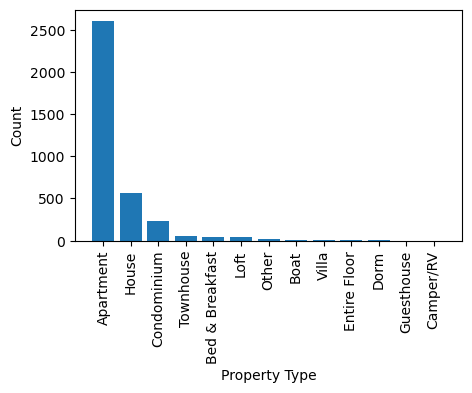

In [172]:
# Counting the occurrences of each unique 'property_type' in the dataset
value_counts = listings['property_type'].value_counts()

print(value_counts)

# Creating a bar plot to visualize the counts of each property type
plt.figure(figsize=(5, 3))  
plt.bar(value_counts.index, value_counts.values) 
plt.xlabel('Property Type')  
plt.ylabel('Count')  
plt.xticks(rotation=90)  
plt.show()  

In [173]:
# Creating a new column 'apartment' to classify properties as apartments (1) or not (0)
listings['apartment'] = np.where((listings['property_type'] == 'Apartment') | 
                                 (listings['property_type'] == 'Condominium') | 
                                 (listings['property_type'] == 'Loft'), 1, 0)

# Creating a new column 'house' to classify properties as houses (1) or not (0)
listings['house'] = np.where((listings['property_type'] == 'House') | 
                             (listings['property_type'] == 'Townhouse') | 
                             (listings['property_type'] == 'Villa') | 
                             (listings['property_type'] == 'Entire Floor') | 
                             (listings['property_type'] == 'Boat'), 1, 0)

# Creating a new column 'other' to classify properties as 'Other' types (1) or not (0)
listings['other'] = np.where((listings['property_type'] == 'Other') | 
                             (listings['property_type'] == 'Dorm') | 
                             (listings['property_type'] == 'Guesthouse') | 
                             (listings['property_type'] == 'Camper/RV '), 1, 0)

### Amenities
Amentities such as Air conditioning, TV, etc. are stored in the "amenities" column as an string variable in the listing data. 
<ul>
<li>Seperating words in the string variable "amenities".</li>
<li>Making dummy variables for each amenity.</li>
<li>Dropping irrelevant columns.</li>
<li>Aggregating similar amenities into a single dummy variable.</li>
</ul>

In [174]:
# Cleaning the 'amenities' column: Removing unwanted characters and splitting the string into a list
amenities = listings['amenities'].map(lambda d: [amenity.replace('"', "")  # Removing double quotes
                                                    .replace("{", "")  # Removing curly braces
                                                    .replace("}", "")  # Removing curly braces
                                                    for amenity in d.split(",")])  # Splitting the string into individual amenities

listings['amenities'] = amenities  # Updating the 'amenities' column with cleaned data

# Creating dummy variables for each unique amenity by expanding the 'amenities' list into columns
amenities = pd.get_dummies(listings['amenities'].apply(pd.Series).stack()).groupby(level=0).sum()

amenities.columns

# Dropping unwanted columns that contain empty strings or translation missing data
amenities = amenities.drop('', axis=1)
amenities = amenities.drop('translation missing: en.hosting_amenity_49', axis=1)
amenities = amenities.drop('translation missing: en.hosting_amenity_50', axis=1)

# Creating a new 'Pets' variable by combining multiple pet-related amenities into one binary variable
amenities['Pets'] = (amenities['Cat(s)'] | amenities['Dog(s)'] | amenities['Other pet(s)'] | amenities['Pets Allowed']).astype(int)
amenities = amenities.drop('Cat(s)', axis=1)  # Dropping individual pet columns
amenities = amenities.drop('Dog(s)', axis=1)
amenities = amenities.drop('Other pet(s)', axis=1)
amenities = amenities.drop('Pets Allowed', axis=1)

# Creating a new 'Internet-conn' variable by combining internet-related amenities
amenities['Internet-conn'] = (amenities['Internet'] | amenities['Wireless Internet']).astype(int)
amenities = amenities.drop('Internet', axis=1)  # Dropping individual internet columns
amenities = amenities.drop('Wireless Internet', axis=1)

# Creating a new 'Washer-Dryer' variable by combining washer-related amenities
amenities['Washer-Dryer'] = (amenities['Washer'] | amenities['Washer / Dryer']).astype(int)
amenities = amenities.drop('Washer', axis=1)  # Dropping individual washer columns
amenities = amenities.drop('Washer / Dryer', axis=1)

# Creating a new 'TV' variable by combining TV-related amenities
amenities['TV-'] = (amenities['Cable TV'] | amenities['TV']).astype(int)
amenities = amenities.drop('Cable TV', axis=1)  # Dropping individual TV columns
amenities = amenities.drop('TV', axis=1)

# Renaming 'TV-' column to 'TV' for clarity
amenities.rename(columns={'TV-': 'TV'}, inplace=True)

amenities

,24-Hour Check-in,Air Conditioning,Breakfast,Buzzer/Wireless Intercom,Carbon Monoxide Detector,Doorman,Dryer,Elevator in Building,Essentials,Family/Kid Friendly,Fire Extinguisher,First Aid Kit,Free Parking on Premises,Free Parking on Street,Gym,Hair Dryer,Hangers,Heating,Hot Tub,Indoor Fireplace,Iron,Kitchen,Laptop Friendly Workspace,Lock on Bedroom Door,Paid Parking Off Premises,Pets live on this property,Pool,Safety Card,Shampoo,Smoke Detector,Smoking Allowed,Suitable for Events,Wheelchair Accessible,Pets,Internet-conn,Washer-Dryer,TV
0,0,0,0,0,0,0,1,0,1,1,1,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,1,0,0,0,1,1,1,1
1,0,1,0,0,1,0,1,0,1,1,1,0,0,0,0,1,1,1,0,0,1,1,0,1,0,1,0,0,1,1,0,0,0,1,1,1,1
2,0,1,0,0,1,0,1,0,1,0,0,1,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,1,1,0,0,0,0,1,1,1
3,0,1,1,0,1,0,1,0,1,0,1,1,1,0,1,1,1,1,0,1,1,1,1,0,0,0,0,1,1,1,0,0,0,0,1,1,1
4,0,1,1,0,1,0,0,0,1,0,0,1,0,0,0,1,1,1,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3580,1,1,0,0,1,0,0,0,1,1,1,0,1,0,0,1,1,1,0,0,1,1,1,1,0,0,0,0,1,1,0,0,0,0,1,0,0
3581,1,1,0,0,1,0,1,1,1,1,1,0,1,0,1,1,1,1,0,0,0,1,1,0,0,1,0,0,1,1,1,0,0,1,1,1,1
3582,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3583,0,0,0,0,0,0,1,0,1,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


Some amenities have too few observations and are dropped from the regression analysis.

In [175]:
print(amenities.shape)

# Summing up the values of 'Free Parking on Street' and 'Paid Parking Off Premises' columns
# This will give the count of occurrences where each amenity is present (1) in the dataset
amenities[['Free Parking on Street', 'Paid Parking Off Premises']].sum()

(3585, 37)


Free Parking on Street       9
Paid Parking Off Premises    4
dtype: int64

In [176]:
# Concatenating the 'amenities' DataFrame with the original 'listings' DataFrame along columns (axis=1)
# This combines the amenities dummy variables with the listings data
listings = pd.concat([listings, amenities], axis=1)

## Boston Geospatial Data
Boston Neighborhood Boundaries Approximated by 2020 Census Block Groups are taken from 
 __[ANALYZE BOSTON](https://data.boston.gov/dataset/boston-neighborhood-boundaries-approximated-by-2020-census-block-groups1)__.
 
 <ul>
<li>Assigning neigborhood according to the latitude and logitude values in the listing dataset.</li>
<li>Making dummy variables for each neighborhood.</li>
</ul>
 

In [177]:
# Reading the GeoJSON file containing the Boston neighborhood boundaries into a GeoDataFrame
boston = gpd.read_file('Boston_Neighborhood_Boundaries_Approximated_by_2020_Census_Block_Groups_new.geojson')

boston['geometry'].head()

0    POLYGON ((-71.12123 42.36775, -71.12175 42.367...
1    POLYGON ((-71.07315 42.35554, -71.07330 42.355...
2    POLYGON ((-71.06291 42.36123, -71.06322 42.361...
3    POLYGON ((-71.13737 42.35876, -71.13729 42.358...
4    POLYGON ((-71.06700 42.39401, -71.06695 42.394...
Name: geometry, dtype: geometry

In [178]:
# Displaying the Coordinate Reference System (CRS) of the 'boston' GeoDataFrame
boston.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

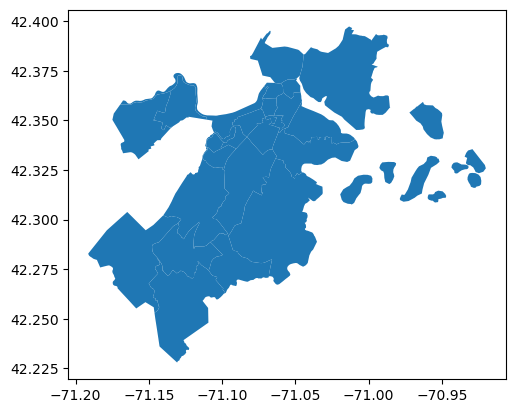

In [179]:
# Plotting the spatial data of the 'boston' GeoDataFrame (neighborhood boundaries)
boston.plot()

Creating "listings_geo_pd" DataFrame and adding a geometry column that contains Point objects representing the longitude and latitude values from each row in the "listing" DataFrame.

In [180]:
# Converting the 'listings' DataFrame into a GeoDataFrame by creating Point geometry
# For each listing, a Point object is created using the 'longitude' and 'latitude' columns
listings_geo_pd = gpd.GeoDataFrame(listings, geometry=listings.apply(
        lambda srs: shapely.geometry.Point(srs['longitude'], srs['latitude']), axis='columns'))

**Density of Airbnb listings**

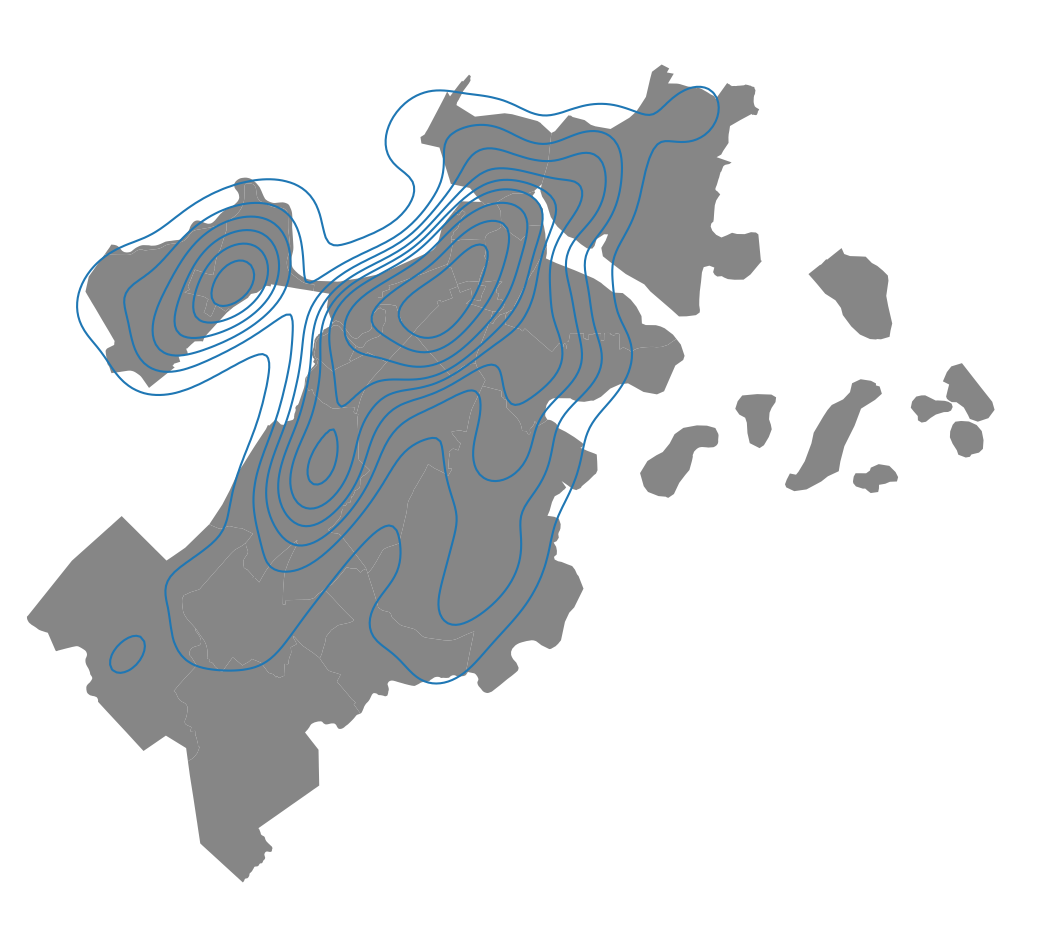

In [181]:
# Creating a figure with specified size for plotting
f = plt.figure(figsize=(20, 12))

# Getting the current axes for the plot
ax = f.gca()

# Plotting the Boston neighborhood boundaries with grey color and slight transparency
boston.plot(ax=ax, alpha=0.95, linewidth=0.25, color='grey')

# Plotting a Kernel Density Estimation (KDE) plot for the locations of listings, using longitude ('x') and latitude ('y')
# KDE is a smooth estimate of the point density, showing where listings are most concentrated
sns.kdeplot(data=listings_geo_pd.apply(lambda srs: pd.Series({'x': srs.geometry.x, 'y': srs.geometry.y}), axis='columns'),
            ax=ax, x='x', y='y', alpha=1)

# Hiding the axis for a cleaner map visualization
ax.set_axis_off()

In [182]:
# Defining a function to assign the neighborhood based on the latitude and longitude of a listing
def assign_neighbourhood(bnb):
    ''' 
    Creates a list of boolean values that indicate which neighborhoods contain the latitude and longitude point 
    for a given listing.
    
    Attributes:
        bnb: The row of the DataFrame that contains latitude and longitude for a listing.
        
    Returns:
        If no True values are found in the boolean list, it returns NaN.
        Otherwise, it returns the neighborhood name for the given latitude and longitude point.
    '''
    # Checking which neighborhoods (from 'boston' GeoDataFrame) contain the listing's point (longitude, latitude)
    bools = [geom.contains(bnb['geometry']) for geom in boston['geometry']]
    
    # If the point is inside a neighborhood, return the corresponding neighborhood name
    if True in bools:
        return boston.iloc[bools.index(True)]['blockgr2020_ctr_neighb_name']
    else:
        return np.nan  # Return NaN if the point is not in any neighborhood

# Applying the 'assign_neighbourhood' function to each row in the 'listings_geo_pd' GeoDataFrame
# This assigns the neighborhood name based on the location of the listing (longitude, latitude)
listings_geo_pd['neighbourhood_geo'] = listings_geo_pd.apply(assign_neighbourhood, axis='columns')

48 listings are not assigned to a neighbourhood.

In [183]:
# Checking the number of listings that do not have a neighborhood assigned (i.e., the 'neighbourhood_geo' column is NaN)
listings_geo_pd['neighbourhood_geo'].isnull().sum()

48

In [184]:
# Creating dummy variables for the 'neighbourhood_geo' column, 
# which will convert the neighborhood names into separate binary columns (1 for presence, 0 for absence)
dummy_variables = pd.get_dummies(listings_geo_pd['neighbourhood_geo'], prefix='d', prefix_sep='_')

# Adding the newly created dummy variables as columns to the 'listings_geo_pd' DataFrame
listings_geo_pd = pd.concat([listings_geo_pd, dummy_variables], axis=1)

listings_geo_pd.head(3)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,date,year,month,apartment,house,other,24-Hour Check-in,Air Conditioning,Breakfast,Buzzer/Wireless Intercom,Carbon Monoxide Detector,Doorman,Dryer,Elevator in Building,Essentials,Family/Kid Friendly,Fire Extinguisher,First Aid Kit,Free Parking on Premises,Free Parking on Street,Gym,Hair Dryer,Hangers,Heating,Hot Tub,Indoor Fireplace,Iron,Kitchen,Laptop Friendly Workspace,Lock on Bedroom Door,Paid Parking Off Premises,Pets live on this property,Pool,Safety Card,Shampoo,Smoke Detector,Smoking Allowed,Suitable for Events,Wheelchair Accessible,Pets,Internet-conn,Washer-Dryer,TV,geometry,neighbourhood_geo,d_Allston,d_Back Bay,d_Beacon Hill,d_Brighton,d_Charlestown,d_Chinatown,d_Dorchester,d_Downtown,d_East Boston,d_Fenway,d_Hyde Park,d_Jamaica Plain,d_Longwood,d_Mattapan,d_Mission Hill,d_North End,d_Roslindale,d_Roxbury,d_South Boston,d_South Boston Waterfront,d_South End,d_West End,d_West Roxbury
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",NaN,"The bus stop is 2 blocks away, and frequent. B...","You will have access to 2 bedrooms, a living r...",NaN,Clean up and treat the home the way you'd like...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,31303940,https://www.airbnb.com/users/show/31303940,Virginia,2015-04-15,"Boston, Massachusetts, United States",We are country and city connecting in our deck...,NaN,NaN,NaN,0,https://a2.muscache.com/im/pictures/5936fef0-b...,https://a2.muscache.com/im/pictures/5936fef0-b...,Roslindale,1,1,"['email', 'phone', 'facebook', 'reviews']",t,f,"Birch Street, Boston, MA 02131, United States",Roslindale,Roslindale,NaN,Boston,MA,02131,Boston,"Boston, MA",US,United States,42.282619,-71.133068,t,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,"[TV, Wireless Internet, Kitchen, Free Parking ...",NaN,250,NaN,NaN,NaN,35.0,1,0,2,1125,2 weeks ago,NaN,0,0,0,0,2016-09-06,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN,2016-09-07,2016,9,0,1,0,0,0,0,0,0,0,1,0,1,1,1,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,1,0,0,0,1,1,1,1,POINT (-71.13307 42.28262),Roslindale,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet fr

**Number of Airbnb listings in each neighborhood**

['Allston' 'Back Bay' 'Beacon Hill' 'Brighton' 'Charlestown' 'Chinatown'
 'Dorchester' 'Downtown' 'East Boston' 'Fenway' 'Harbor Islands'
 'Hyde Park' 'Jamaica Plain' 'Longwood' 'Mattapan' 'Mission Hill'
 'North End' 'Roslindale' 'Roxbury' 'South Boston'
 'South Boston Waterfront' 'South End' 'West End' 'West Roxbury']


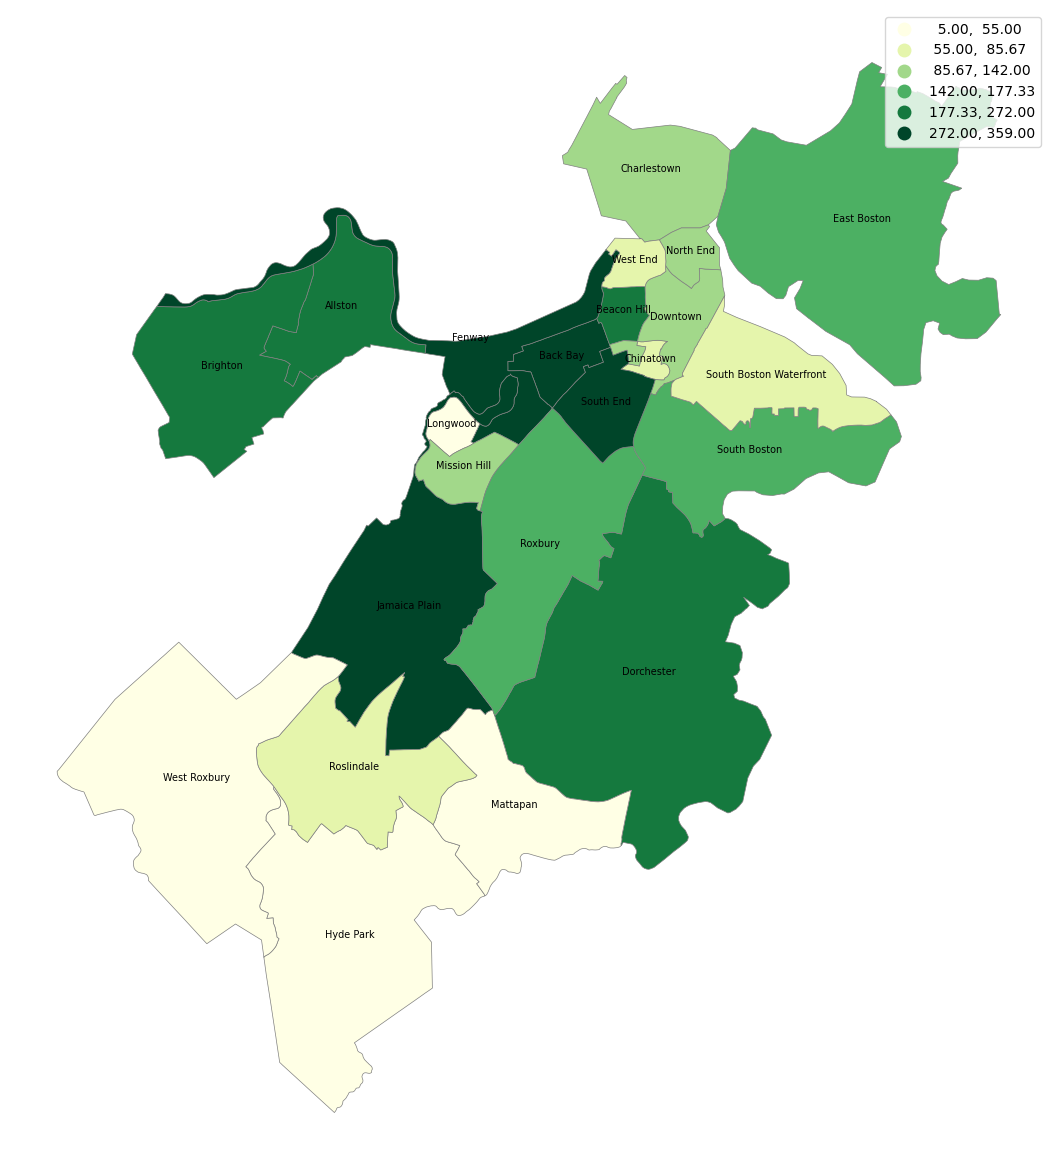

In [185]:
# Mapping the 'neighbourhood_geo' values from 'listings_geo_pd' to the 'BNBs' column in 'boston' GeoDataFrame
# This counts the number of listings in each neighborhood and assigns that count to the corresponding neighborhood
boston['BNBs'] = boston['blockgr2020_ctr_neighb_name'].map(listings_geo_pd['neighbourhood_geo'].value_counts())

# Printing the unique neighborhood names in the 'blockgr2020_ctr_neighb_name' column
print(boston['blockgr2020_ctr_neighb_name'].unique())

# Defining a function to create a choropleth plot that visualizes the density of a given column (e.g., 'BNBs')
def choropleth(col):
    '''Creates a choropleth plot to show the density of the specified column 
       (e.g., BNBs, BNB_density, or price). The column should contain numeric values.'''

    f = plt.figure(figsize=(25, 15))
    ax = f.gca()
    
    # Setting plotting options, such as color scheme, quantile classification, and edge style
    kw = dict(column=col, k=6, cmap='YlGn', alpha=1, legend=True, edgecolor='gray', linewidth=0.5)
    
    # Plotting the 'boston' GeoDataFrame with the specified options
    boston.plot(scheme='QUANTILES', ax=ax, **kw)
    
    # Annotating each neighborhood with its name at the centroid of its geometry
    boston.apply(lambda x: ax.annotate(fontsize=7, text=x['blockgr2020_ctr_neighb_name'], 
                                       xy=x.geometry.centroid.coords[0], ha='center'), axis=1)
    
    ax.set_axis_off()

# Creating a choropleth map for the 'BNBs' column to visualize the number of listings in each neighborhood
ax = choropleth('BNBs')

plt.savefig('BNBs_choropleth.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()

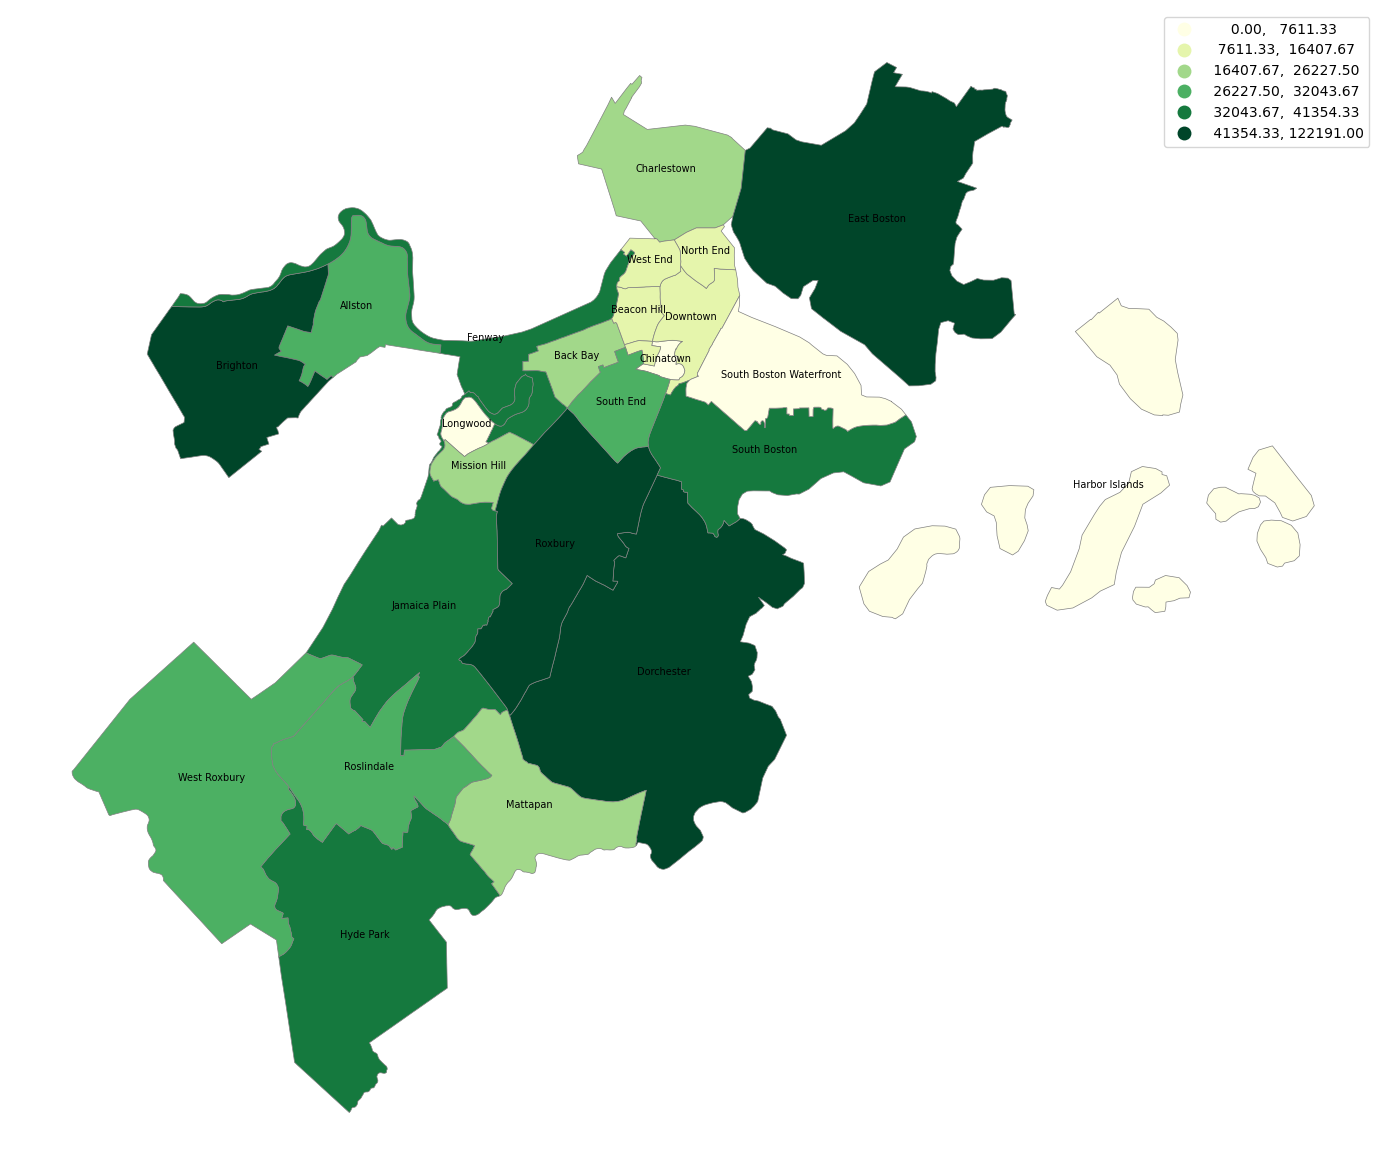

In [186]:
# Creating a choropleth map for the 'tot_pop_all' column to visualize the population density in each neighborhood
ax = choropleth('tot_pop_all')

plt.savefig('tot_pop_all_choropleth.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()

In [187]:
# Creating a new variable 'prop_type' in the 'listings_geo_pd' DataFrame to store the property type based on the dummy variables
listings_geo_pd['prop_type'] = ''

# Looping through each row of the DataFrame to assign a property type based on the dummy variables
for index, row in listings_geo_pd.iterrows():
    if row['apartment'] == 1:
        listings_geo_pd.at[index, 'prop_type'] = 'apartment'
    elif row['house'] == 1:
        listings_geo_pd.at[index, 'prop_type'] = 'house'
    elif row['other'] == 1:
        listings_geo_pd.at[index, 'prop_type'] = 'other'

**Because there are too few observations of size of the listing, the number of people a listing accommodates or the number of bedroom are considered approximations for the size of the listing.**

In [188]:
# Displaying basic descriptive statistics 
listings_geo_pd[['square_feet', 'accommodates', 'guests_included', 'bedrooms']].describe()

,square_feet,accommodates,guests_included,bedrooms
count,56.000000,3585.000000,3585.000000,3575.000000
mean,858.464286,3.041283,1.429847,1.255944
std,608.874310,1.778929,1.056787,0.753060
min,0.000000,1.000000,0.000000,0.000000
25%,415.000000,2.000000,1.000000,1.000000
50%,825.000000,2.000000,1.000000,1.000000
75%,1200.000000,4.000000,1.000000,2.000000
max,2400.000000,16.000000,14.000000,5.000000


In [189]:
# Creating a new DataFrame 'listings_df' with selected columns from 'listings_geo_pd' to focus on relevant data for analysis
listings_df = listings_geo_pd[['prop_type', 'property_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'cleaning_fee', 'geometry', 'neighbourhood_geo']].copy()

# Calculate price per room and price per guest if needed 
# listings_pd_ppl['price_room'] = (listings_pd_ppl['price'] + listings_pd_ppl['cleaning_fee']) / listings_pd_ppl['bedrooms']
# listings_pd_ppl['price_guest'] = (listings_pd_ppl['price'] + listings_pd_ppl['cleaning_fee']) / listings_pd_ppl['accommodates']

# Creating a 'price_room' column by dividing the price by the number of bedrooms, showing price per room
listings_df['price_room'] = (listings_df['price']) / listings_df['bedrooms']

# Creating a 'price_guest' column by dividing the price by the number of accommodates (guests), showing price per guest
listings_df['price_guest'] = (listings_df['price']) / listings_df['accommodates']

# Creating a 'weighted_price' column by averaging the 'price_room' and 'price_guest' values to get a balanced price metric
listings_df['weighted_price'] = (listings_df['price_room'] + listings_df['price_guest']) / 2

# Replacing empty string values in 'prop_type' column with NaN to prepare for clean data
listings_df['prop_type'] = listings_df['prop_type'].replace("", np.nan)

# Dropping any rows with NaN values in the 'listings_df' DataFrame to ensure no missing data for analysis
listings_df = listings_df.dropna()

listings_df

,prop_type,property_type,accommodates,bathrooms,bedrooms,beds,price,cleaning_fee,geometry,neighbourhood_geo,price_room,price_guest,weighted_price
0,house,House,4,1.5,2.0,3.0,250,35.0,POINT (-71.13307 42.28262),Roslindale,125.0,62.500000,93.750000
1,apartment,Apartment,2,1.0,1.0,1.0,65,10.0,POINT (-71.13437 42.28624),Roslindale,65.0,32.500000,48.750000
2,apartment,Apartment,2,1.0,1.0,1.0,65,0.0,POINT (-71.13577 42.29244),Roslindale,65.0,32.500000,48.750000
3,house,House,4,1.0,1.0,2.0,75,50.0,POINT (-71.12102 42.28111),Roslindale,75.0,18.750000,46.875000
4,house,House,2,1.5,1.0,2.0,79,15.0,POINT (-71.13626 42.28451),Roslindale,79.0,39.500000,59.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3532,apartment,Apartment,1,1.0,1.0,1.0,28,10.0,POINT (-71.12512 42.35288),Allston,28.0,28.000000,28.000000
3533,house,House,4,1.0,1.0,2.0,75,35.0,POINT (-71.14047 42.35201),Allston,75.0,18.750000,46.875000
3534,apartment,Apartment,2,1.0,1.0,1.0,129,0.0,POINT (-71.13434 42.34721),Allston,129.0,64.500000,96.750000
3535,apartment,Apartment,2,1.0,1.0,1.0,50,25.0,POINT (-71.13521 42.34707),Allston,50.0,25.000000,37.500000


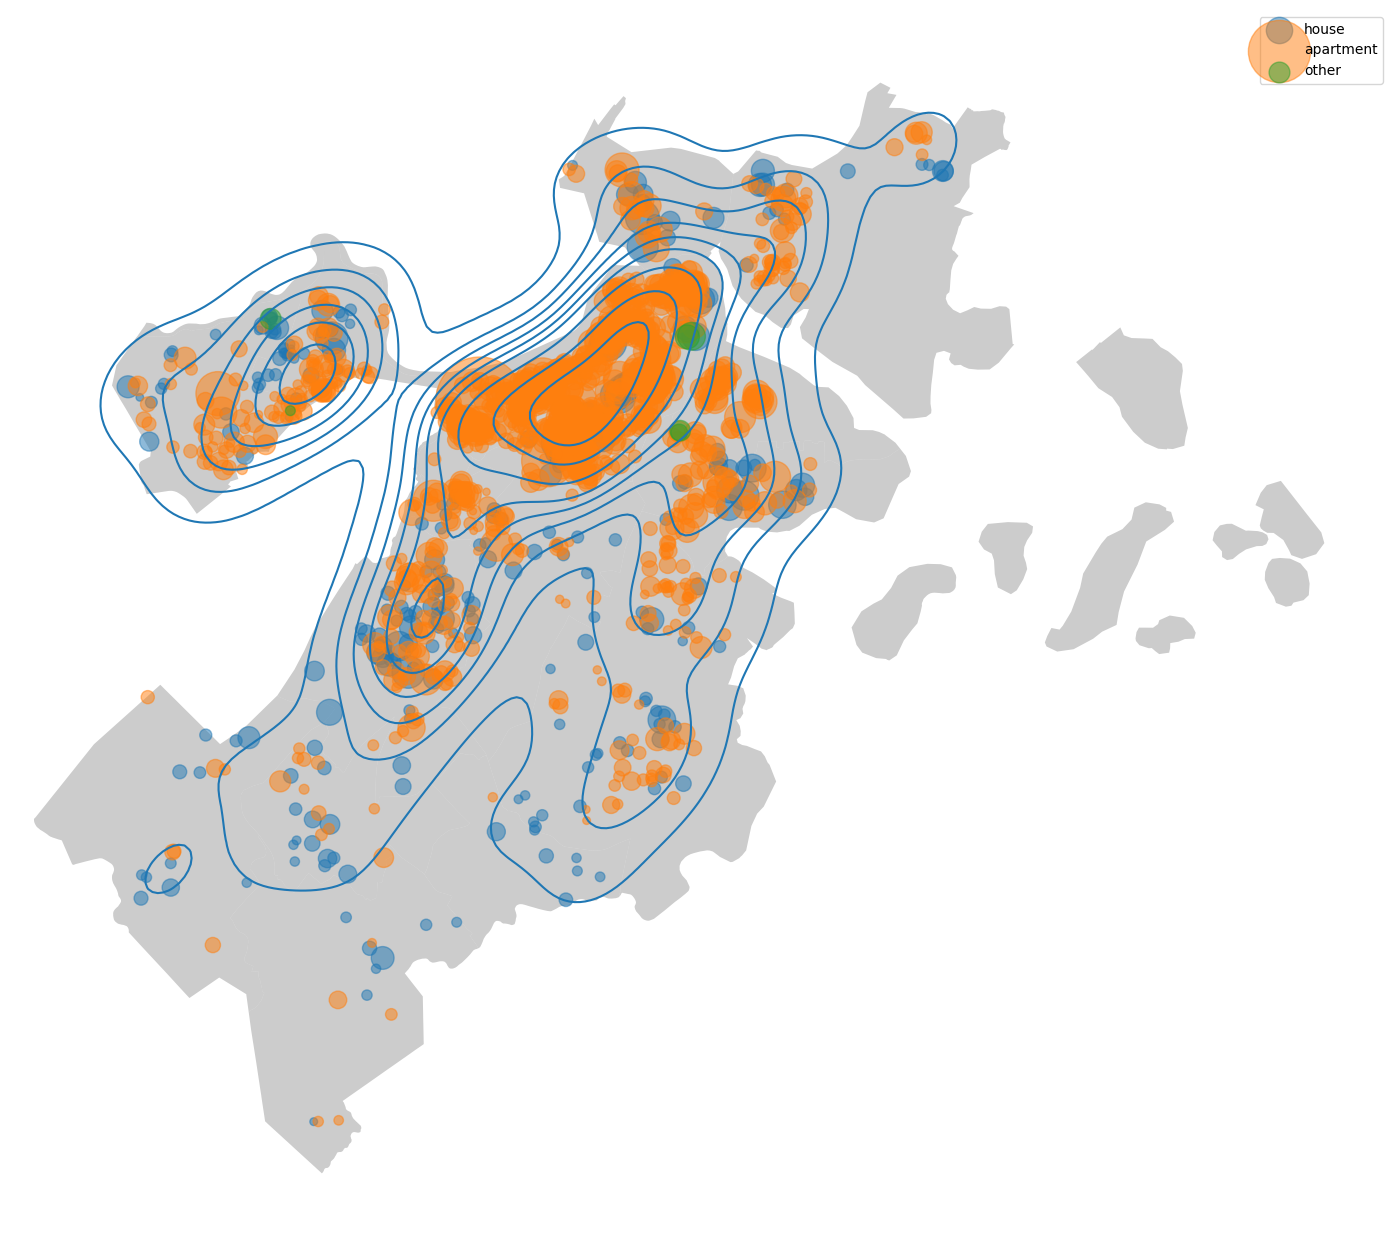

In [190]:
# Define a function 'plot_scatter' that creates a scatter plot on the Boston map, with point sizes depending on the price of listings
def plot_scatter(col, type = ''):
    '''Plots a scatter plot on the Boston map.
    The size of the points in the scatter plot is dependent on the 
    price of the listings. 
    
    Attributes:
        col: The column that we want to visualize on the Boston map. 
             It can be 'property_type', 'bedrooms', 'accommodates', or any other column.
        type: For a specific column, we can visualize a particular value. 
              For example, for 'property_type', we can visualize only apartments or houses in Boston.
    '''
    
    fig, ax = plt.subplots(figsize=(25, 16))
    
    # Randomly sample 1500 entries from the listings_df DataFrame to plot on the map
    sample = listings_df.sample(1500)
    
    # Generate random colors for the scatter plot (based on the unique values in the specified column)
    colors = np.random.rand(len(listings_df[col].unique()))
    
    # Plot the Boston map as the base layer
    base = boston.plot(ax=ax, alpha=0.4, linewidth=0.25, color='grey')
    
    # Plot a KDE (Kernel Density Estimation) plot to show density of listings by their x and y coordinates
    sns.kdeplot(data=listings_df.apply(lambda srs: pd.Series({'x': srs.geometry.x, 'y': srs.geometry.y}), axis='columns'), ax=ax,
                x='x', y='y', alpha=1)
    
    # If no specific type is passed, plot listings for all unique values in the selected column
    if type == '':
        for i in listings_df[col].unique():    
            # Get the x and y coordinates for listings where the value in the column matches 'i'
            x_cor = sample[sample[col]==i].geometry.x
            y_cor = sample[sample[col]==i].geometry.y
            
            # Scatter plot: positions based on x and y, size of points based on price, and transparency (alpha)
            ax.scatter(x_cor, y_cor, label=i, s=sample['price'][sample[col]==i], alpha=0.5)
    
    # If a specific type is passed, only plot listings with that type
    else:
        # Get the x and y coordinates for listings matching the specified 'type'
        x_cor = sample[sample[col]==type].geometry.x
        y_cor = sample[sample[col]==type].geometry.y
        
        # Scatter plot: positions based on x and y, size of points based on price, and transparency (alpha)
        ax.scatter(x_cor, y_cor, label=type, s=sample['price'][sample[col]==type], alpha=0.5)

    ax.legend()
    
    ax.set_axis_off()
    
    return fig, ax

fig, ax = plot_scatter('prop_type')

fig.savefig('boston_property_type_scatter.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()

# Linear Regression Model

To see which factors affect the pricing of the listings, a linear regression model is estimated. 

In [191]:
# Defining explanatory variables and price-related variables
explanatory_variables = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'guests_included', 'apartment', 'house', 'host_is_superhost', 'reviews_per_month', 'review_scores_rating']
availability_vars = ['availability_30', 'availability_60', 'availability_90']
amenities_list = ['24-Hour Check-in', 'Air Conditioning', 'Breakfast', 'Elevator in Building', 'Essentials', 'Family/Kid Friendly', 'Free Parking on Premises', 'Gym', 'Heating', 'Hot Tub', 'Kitchen', 'Pool', 'Smoking Allowed', 'Suitable for Events', 'TV', 'Wheelchair Accessible', 'Pets', 'Internet-conn', 'Washer-Dryer']
dummy_variables = listings_geo_pd.filter(regex='^d_').columns.to_list()
price_variables = ['price', 'extra_people', 'cleaning_fee']

# Dropping one neighborhood dummy to avoid multicollinearity
elements_to_drop = ['d_Mattapan']  
dummy_vars = [x for x in dummy_variables if x not in elements_to_drop]

# Defining cluster variable (neighborhood)
cluster = ['neighbourhood_geo']

# Creating DataFrame for regression analysis
valid_listings = listings_geo_pd[explanatory_variables + price_variables + availability_vars + amenities_list + dummy_vars + cluster]

## Missing Values

All variables used for the analysis are in the "valid_listings" dataframe.

<ul>
<li>For the "reviews_per_month" and "review_scores_rating" the number of missing values is too large compared to the total number of the listings, therefore, I replace the missing values with the average of the number of reviews per month, and the average review score rating, respectively.</li>
<li>However, the number of missing values for "bathrooms", "bedrooms", "beds", and "neighbourhood_geo" is small compared to the size of the sample, therefore, listings with these missing values are dropped.</li>
<li>Because many values of "square_feet" are missing, the number of people a listing accommodates or the number of bedroom are considered approximations for the size of the listing and the price of the listing is normalized using these approximations.</li>
<li>Missing values of cleaning_fee are replaced with zero, assuming that most probably it is not charged. However, it is not used in the analysis.</li>
</ul>

In [192]:
print(valid_listings.shape)
valid_listings.isna().sum()

(3585, 58)


accommodates                   0
bathrooms                     14
bedrooms                      10
beds                           9
guests_included                0
apartment                      0
house                          0
host_is_superhost              0
reviews_per_month            756
review_scores_rating         813
price                          0
extra_people                   0
cleaning_fee                   0
availability_30                0
availability_60                0
availability_90                0
24-Hour Check-in               0
Air Conditioning               0
Breakfast                      0
Elevator in Building           0
Essentials                     0
Family/Kid Friendly            0
Free Parking on Premises       0
Gym                            0
Heating                        0
Hot Tub                        0
Kitchen                        0
Pool                           0
Smoking Allowed                0
Suitable for Events            0
TV        

In [193]:
# Replacing the missing values of a feature with the average of the feature (reviews_per_month and review_scores_rating)
valid_listings = valid_listings.copy()
valid_listings['reviews_per_month'].fillna(valid_listings['reviews_per_month'].mean(), inplace = True)
valid_listings['review_scores_rating'].fillna(valid_listings['review_scores_rating'].mean(), inplace = True)

In [194]:
# Dropping the remaining few listings with missing values 
valid_listings = listings_geo_pd[explanatory_variables + price_variables + availability_vars + amenities_list + dummy_vars + cluster].dropna()

In [195]:
# Normalizing price by room (price per bedroom)
valid_listings['price_room'] = (valid_listings['price']) / valid_listings['bedrooms']
# valid_listings['price_room'] = (valid_listings['price'] + valid_listings['cleaning_fee']) / valid_listings['bedrooms']

# Normalizing price by guest (price per accommodated guest)
valid_listings['price_guest'] = ((valid_listings['accommodates'] - valid_listings['guests_included']) * valid_listings['extra_people'] + valid_listings['price']) / valid_listings['accommodates']
# valid_listings['price_guest'] = ((valid_listings['accommodates'] - valid_listings['guests_included']) * valid_listings['extra_people'] + valid_listings['price'] + valid_listings['cleaning_fee']) / valid_listings['accommodates']


# Calculating weighted price (average of price per room and per guest)
valid_listings['weighted_price'] = (valid_listings['price_room'] + valid_listings['price_guest']) / 2

# Replacing inf and NaN values, then dropping rows with NaNs
valid_listings.replace([np.inf, -np.inf], np.nan, inplace=True)
valid_listings = valid_listings.dropna()

# Descriptive statistics for price-related variables
valid_listings[['price', 'cleaning_fee', 'price_room', 'price_guest', 'weighted_price']].describe()

,price,cleaning_fee,price_room,price_guest,weighted_price
count,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,168.764400,45.406800,125.671947,62.105993,93.888970
std,117.686503,49.374387,69.291697,31.404045,47.366020
min,11.000000,0.000000,11.000000,5.500000,8.250000
25%,80.000000,0.000000,75.000000,40.958333,58.750000
50%,145.000000,30.000000,105.000000,55.000000,82.500000
75%,225.000000,75.000000,160.250000,75.000000,116.796875
max,1300.000000,300.000000,699.000000,500.000000,500.000000


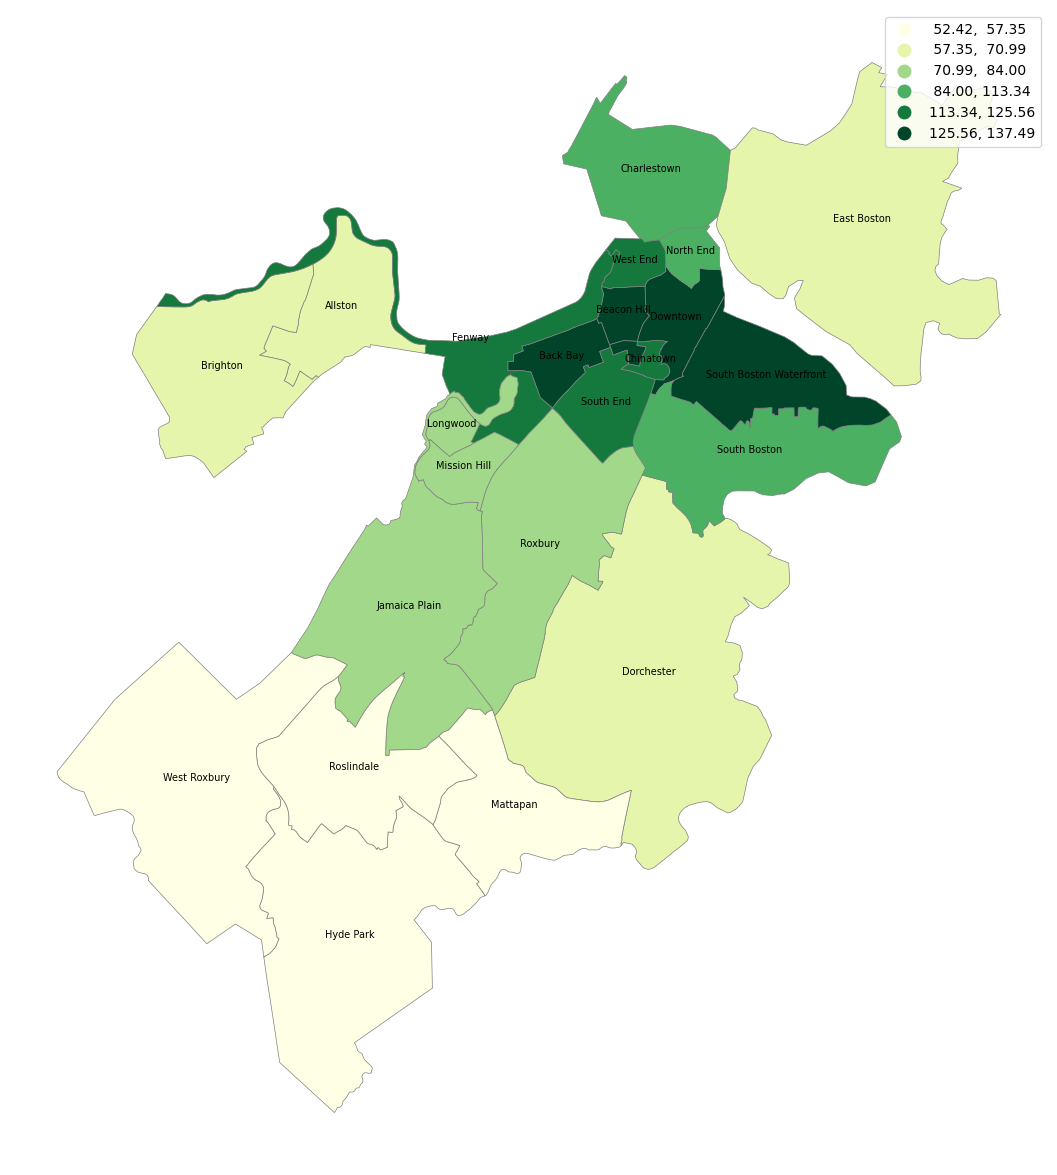

In [196]:
# Mapping the weighted_price from valid listings to the Boston neighborhoods
boston['weighted_price'] = boston['blockgr2020_ctr_neighb_name'].map(valid_listings.groupby(['neighbourhood_geo']).mean()['weighted_price'])

# Create the choropleth map based on weighted_price
ax = choropleth('weighted_price')

plt.savefig('weighted_price_choropleth.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()

In [197]:
# Adding a constant to the valid_listings DataFrame for the intercept term in the OLS regression
valid_listings = sm.add_constant(valid_listings)

const = ['const'] 

valid_listings['bathrooms_2'] = valid_listings['bathrooms']**2

# Define the explanatory variables for the regression model
explanatory_variables = ['bathrooms', 'bathrooms_2', 'apartment', 'house', 'availability_90', 'host_is_superhost', 'reviews_per_month', 'review_scores_rating']

# Fit an OLS regression model using the weighted_price as the dependent variable and the specified explanatory variables
clf = sm.OLS(valid_listings['weighted_price'], valid_listings[const + explanatory_variables + amenities_list + dummy_vars])

# Fit the model using heteroskedasticity-consistent standard errors (HC3)
basic_ols_res = clf.fit(cov_type='HC3')

# Fit the OLS regression model with clustered standard errors by neighborhood
#basic_ols_res = clf.fit(cov_type='cluster', cov_kwds={'groups': valid_listings['neighbourhood_geo']})

# Display the summary of the regression results
basic_ols_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         weighted_price   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     46.94
Date:                Sun, 15 Dec 2024   Prob (F-statistic):          9.13e-311
Time:                        04:19:18   Log-Likelihood:                -12432.
No. Observations:                2500   AIC:                         2.496e+04
Df Residuals:                    2450   BIC:                         2.526e+04
Df Model:                          49                                         
Covariance Type:                  HC3                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        41.4667     18.565      2.234      0.026       5.080      77.854
bathrooms                   -20.2270      4.775     -4.236      0.000     -29.586     -10.868
bathrooms_2                   3.5959      1.056      3.405      0.001       1.526       5.666
apartment                    -1.9530     11.162     -0.175      0.861     -23.831      19.925
house                         0.0123     10.778      0.001      0.999     -21.112      21.136
availability_90               0.2597      0.030      8.800      0.000       0.202       0.318
host_is_superhost             7.7664      2.175      3.570      0.000       3.503      12.030
reviews_per_month            -3.1510      0.334     -9.422      0.000      -3.806      -2.495
review_scores_rating          0.2345      0.085      2.758      0.006       0.068       0.401
24-Hour Check-in             -1.4671      1.689     -0.869      0.385      -4.777       1.843
Air Conditioning              8.3674      1.731      4.835      0.000       4.975      11.759
Breakfast                     7.0790      3.131      2.261      0.024       0.943      13.216
Elevator in Building         10.2285      3.330      3.071      0.002       3.701      16.756
Essentials                    0.5106      2.019      0.253      0.800      -3.447       4.468
Family/Kid Friendly          -1.6645      1.536     -1.083      0.279      -4.676       1.347
Free Parking on Premises     -1.5003      1.645     -0.912      0.362      -4.724       1.723
Gym                          -3.0776      3.582     -0.859      0.390     -10.098       3.943
Heating                       0.2893      3.669      0.079      0.937      -6.903       7.481
Hot Tub                      -3.2044      2.703     -1.185      0.236      -8.503       2.094
Kitchen                       0.3771      2.207      0.171      0.864      -3.948       4.702
Pool                         -4.2939      5.008     -0.857      0.391     -14.110       5.522
Smoking Allowed             -14.0719      3.762     -3.741      0.000     -21.445      -6.699
Suitable for Events           6.7895      5.902      1.150      0.250      -4.778      18.357
TV                           11.3303      1.559      7.267      0.000       8.274      14.386
Wheelchair Accessible         5.8549      4.434      1.320      0.187      -2.835      14.545
Pets                         -0.1781      1.736     -0.103      0.918      -3.580       3.223
Internet-conn               -10.0486      6.852     -1.467      0.142     -23.477       3.380
Washer-Dryer                  5.2864      1.730      3.056      0.002       1.896       8.677
d_Allston                    15.9478      5.274      3.024      0.002       5.612      26.284
d_Back Bay                   69.6755      6.409     10.871      0.000      

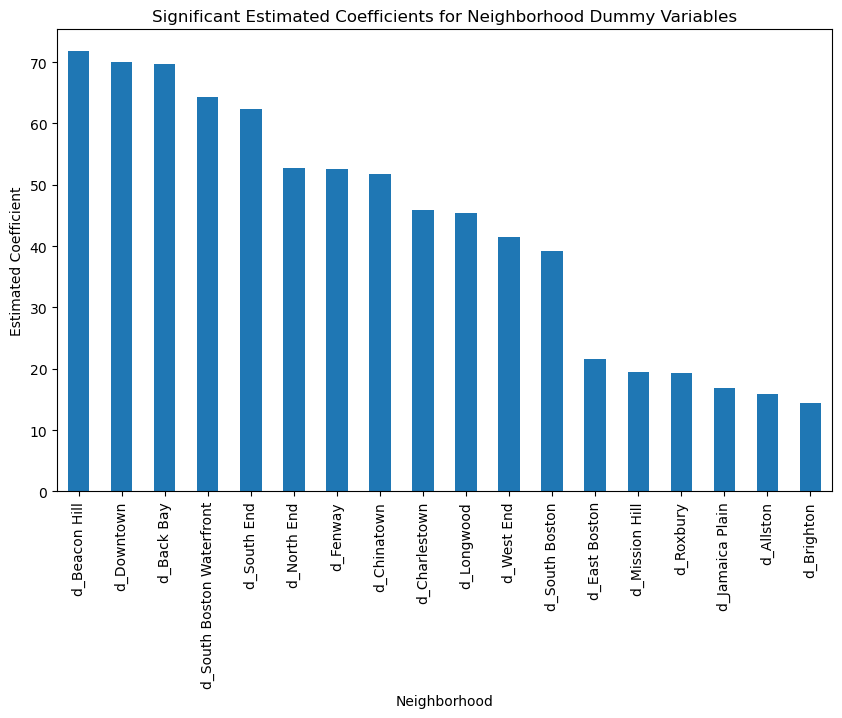

In [198]:
# Extract model coefficients and p-values
coefficients = basic_ols_res.params
p_values = basic_ols_res.pvalues

# Filter for neighborhood dummy variables
neighborhood_dummies = [var for var in dummy_vars]  # Adjust to match your dummy naming pattern
neighborhood_coefficients = coefficients[neighborhood_dummies]
neighborhood_p_values = p_values[neighborhood_dummies]

# Select significant coefficients (p-value < 0.05)
significant_neighborhoods = neighborhood_coefficients[neighborhood_p_values <= 0.05]

# Sort the significant coefficients in descending order
significant_neighborhoods = significant_neighborhoods.sort_values(ascending=False)

# Plot the significant neighborhood coefficients as a bar chart
plt.figure(figsize=(10, 6))
significant_neighborhoods.plot(kind='bar')
plt.xlabel('Neighborhood')
plt.ylabel('Estimated Coefficient')
plt.title('Significant Estimated Coefficients for Neighborhood Dummy Variables')
plt.xticks(rotation=90)

# Save the plot as a JPG file
plt.savefig('Significant_Neighborhood_Dummys.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()

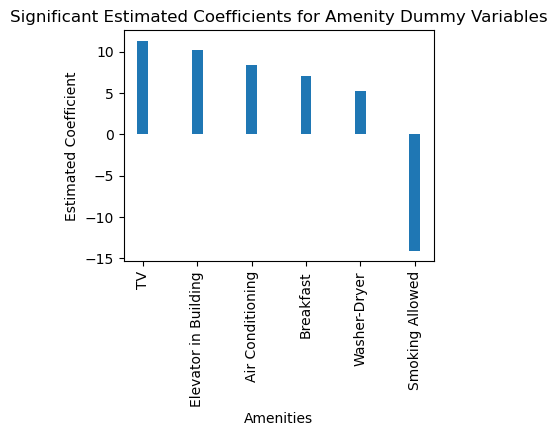

In [199]:
# Extract coefficients and p-values from the OLS regression results
coefficients = basic_ols_res.params
p_values = basic_ols_res.pvalues

# Filter for amenity dummy variables
amenities_dummies = [var for var in amenities_list]  # Adjust to match your amenity naming pattern
amenities_coefficients = coefficients[amenities_dummies]
amenities_p_values = p_values[amenities_dummies]

# Select significant coefficients (p-value < 0.05)
significant_amenities = amenities_coefficients[amenities_p_values <= 0.05]

# Sort the significant coefficients in descending order
significant_amenities = significant_amenities.sort_values(ascending=False)

# Define bar width for visualization
bar_width = 0.2  # Adjust this to make the bars wider or narrower

# Plot the significant amenities coefficients as a bar chart
plt.figure(figsize=(4, 3))
significant_amenities.plot(kind='bar', width=bar_width)
plt.xlabel('Amenities')
plt.ylabel('Estimated Coefficient')
plt.title('Significant Estimated Coefficients for Amenity Dummy Variables')
plt.xticks(rotation=90)

# Save the plot as a JPG file
plt.savefig('Significant_Amenity_Dummys.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()

In [200]:
print(valid_listings.shape)
print(valid_listings['bathrooms'].describe())
print(valid_listings['availability_90'].describe())
print(valid_listings['review_scores_rating'].describe())
print(valid_listings['Free Parking on Premises'].describe())

(2500, 63)
count    2500.00000
mean        1.23660
std         0.51945
min         0.00000
25%         1.00000
50%         1.00000
75%         1.00000
max         6.00000
Name: bathrooms, dtype: float64
count    2500.00000
mean       38.18200
std        31.86024
min         0.00000
25%         1.00000
50%        37.00000
75%        66.00000
max        90.00000
Name: availability_90, dtype: float64
count    2500.000000
mean       92.024400
std         9.593071
min        20.000000
25%        89.000000
50%        95.000000
75%        99.000000
max       100.000000
Name: review_scores_rating, dtype: float64
count    2500.0000
mean        0.2576
std         0.4374
min         0.0000
25%         0.0000
50%         0.0000
75%         1.0000
max         1.0000
Name: Free Parking on Premises, dtype: float64


# Machine Learning Models

Model: Linear Regression
Best Parameters: Default
Mean Squared Error: 1550.7721
R^2 Score: 0.4063
----------------------------------------
Model: Random Forest
Best Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 15, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Mean Squared Error: 1425.0922
R^2 Score: 0.4544
----------------------------------------
Model: XGBoost
Best Parameters: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 

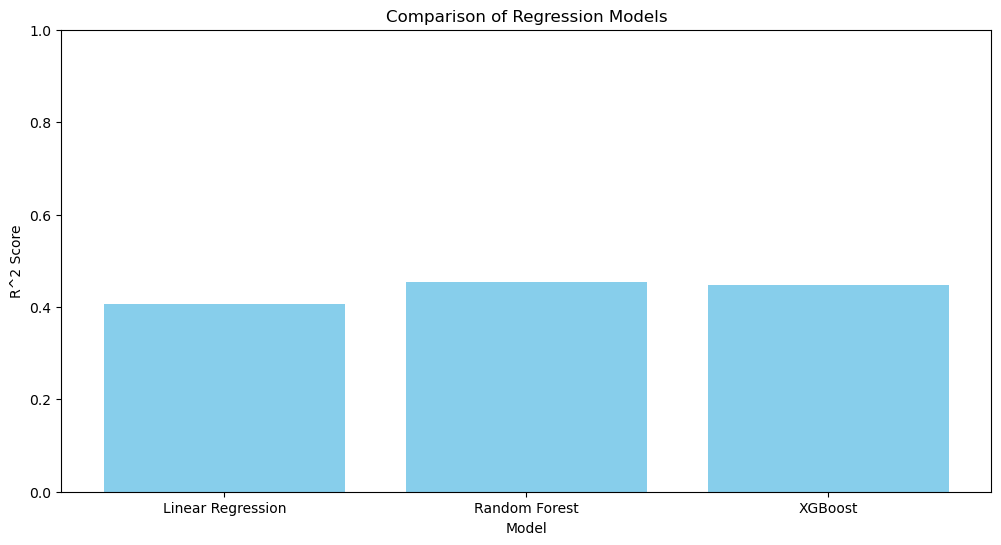

In [201]:
# Define the explanatory variables 
explanatory_variables = ['bathrooms', 'apartment', 'house', 'availability_90', 'host_is_superhost', 'reviews_per_month', 'review_scores_rating']

# Define features and target variable
X = valid_listings[const + explanatory_variables + amenities_list + dummy_vars]
y = valid_listings['weighted_price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the models and hyperparameter grids
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=42)
}

param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 10, 15],
        'min_samples_split': [2, 5, 10]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2]
    }
}

# Dictionary to store the best models and their performances
best_models = {}
results = []

# Train and tune each model
for model_name, model in models.items():
    if model_name in param_grids:  # If the model has hyperparameters to tune
        grid_search = GridSearchCV(model, param_grids[model_name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
    else:
        best_model = model
        best_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = best_model.predict(X_test)

    # Calculate performance metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store the results
    best_models[model_name] = best_model
    results.append({'Model': model_name, 'MSE': mse, 'R^2 Score': r2})

    # Print model performance
    print(f"Model: {model_name}")
    print(f"Best Parameters: {best_model.get_params() if model_name in param_grids else 'Default'}")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"R^2 Score: {r2:.4f}")
    print('-' * 40)

# Create a DataFrame to compare the results
results_df = pd.DataFrame(results)
print(results_df)

# Plot the performance of the models
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(results_df['Model'], results_df['R^2 Score'], color='skyblue')
plt.xlabel('Model')
plt.ylabel('R^2 Score')
plt.title('Comparison of Regression Models')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.show()

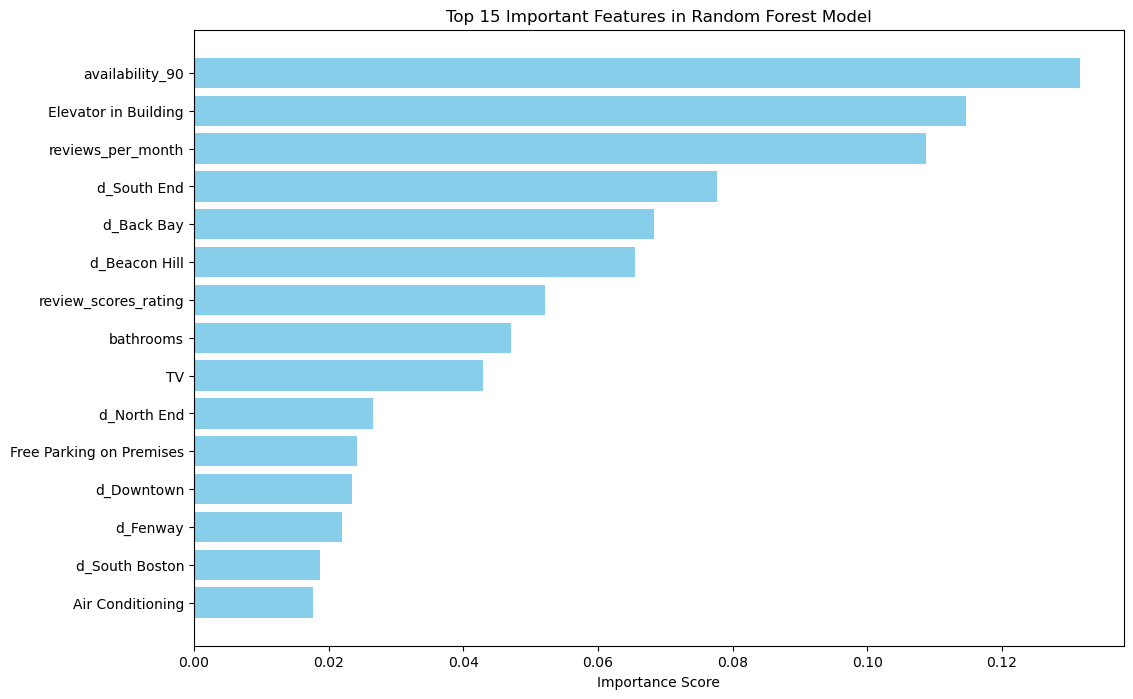

In [202]:
# Assume best_model is the Random Forest Regressor selected earlier
best_rf_model = best_models['Random Forest']

# Get feature importances
feature_importances = best_rf_model.feature_importances_
features = X.columns

# Create a DataFrame of features and their importance scores
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the top 15 important features
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'][:15], importance_df['Importance'][:15], color='skyblue')
plt.xlabel('Importance Score')
plt.title('Top 15 Important Features in Random Forest Model')
plt.gca().invert_yaxis()
plt.savefig('Top_15_Important_Features_Random_Forest.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()

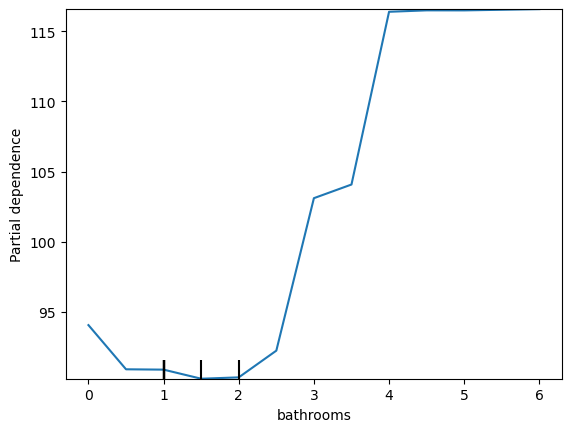

In [203]:
# Plotting partial dependence for the features
PartialDependenceDisplay.from_estimator(best_rf_model, X, features=['bathrooms'])

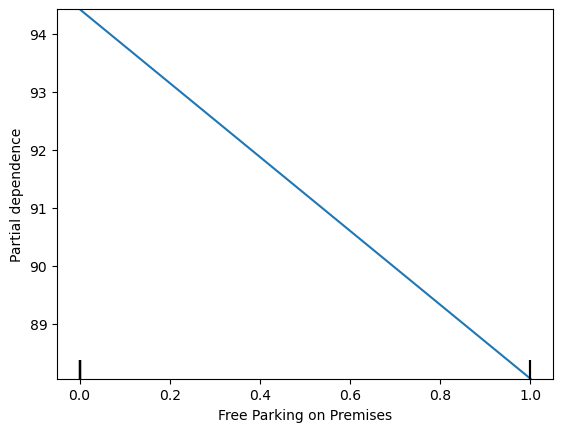

In [204]:
PartialDependenceDisplay.from_estimator(best_rf_model, X, features=['Free Parking on Premises'])

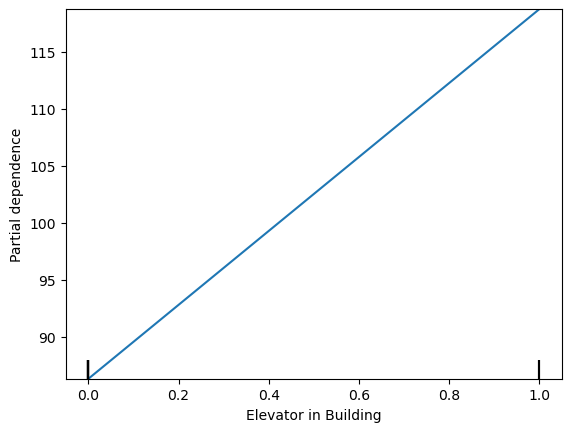

In [205]:
PartialDependenceDisplay.from_estimator(best_rf_model, X, features=['Elevator in Building'])

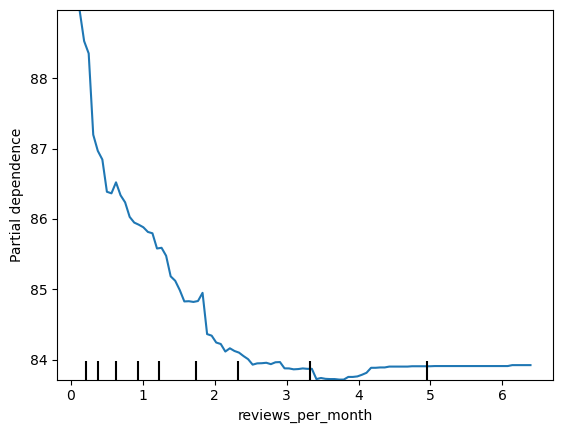

In [206]:
PartialDependenceDisplay.from_estimator(best_rf_model, X, features=['reviews_per_month'])